# Librerias

In [1]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

#Data viz
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.express as px
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
from sklearn.model_selection import KFold, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier

seed = 42

# Lectura

In [3]:
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')

y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')

In [5]:
X_train.head()

,no_of_weekend_nights,year,market_segment_type_Online,day_of_week,market_segment_type_other,no_of_special_requests,required_car_parking_space,avg_price_per_room_mm,repeated_guest,type_of_meal_plan_Not Selected,lead_time_transf,is_wknd
0,1,2018,1,3,0,1,0,0.31,0,1,-0.34,0
1,0,2017,1,1,0,1,0,0.36,0,0,-1.99,0
2,0,2018,1,7,0,1,0,0.84,0,0,-0.24,1
3,2,2018,1,2,0,1,0,0.89,0,0,-0.13,0
4,2,2018,1,4,0,1,0,0.34,0,0,-0.15,0


# Random Forest

In [44]:
param_grid = {
    "n_estimators": [x for x in range(5,201,10)],
    "max_features": ["auto","sqrt","log2"],
    "criterion":["gini","entropy"]
}

kfold = KFold(n_splits=5,shuffle=True,random_state=seed)

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state = seed)
                            ,param_grid=param_grid
                            ,scoring="roc_auc"
                            ,cv=kfold
                            ,n_jobs=-1
                            ,verbose=0
                            ,return_train_score=True)

grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [5, 15, 25, 35, 45, 55, 65, 75, 85, 95,
                                          105, 115, 125, 135, 145, 155, 165,
                                          175, 185, 195]},
             return_train_score=True, scoring='roc_auc')

In [45]:
print(f'Mejor modelo de Decision Tree cuenta con parametros: {grid_search_rf.best_estimator_}')
print(f'El AUC es de: {round(grid_search_rf.best_score_,3)}')

Mejor modelo de Decision Tree cuenta con parametros: RandomForestClassifier(criterion='entropy', max_features='auto',
                       n_estimators=185, random_state=42)
El AUC es de: 0.904


# Visualizacion parametros

Según criterio

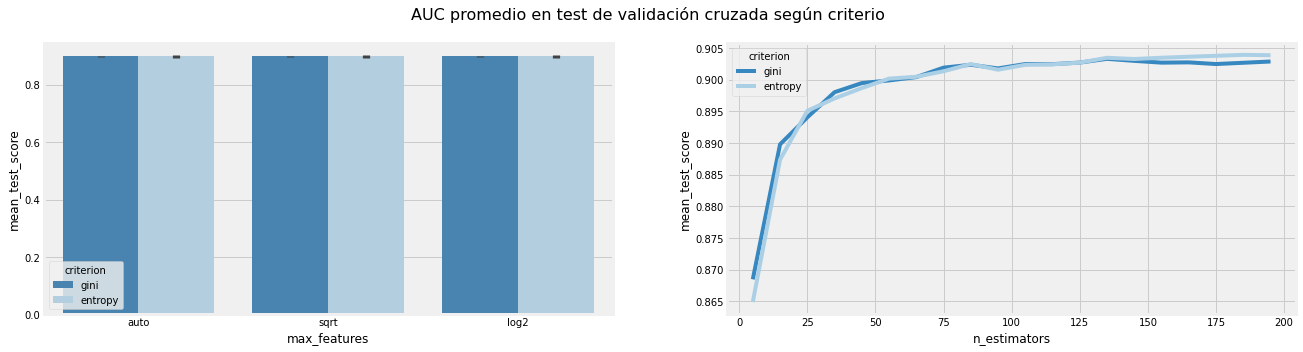

In [47]:
criterion_list = list(grid_search_rf.cv_results_['param_criterion'].data)
max_features_list = list(grid_search_rf.cv_results_['param_max_features'].data)
n_estimators_list = list(grid_search_rf.cv_results_['param_n_estimators'].data)
mean_test_score_list = list(grid_search_rf.cv_results_['mean_test_score'])

decision_tree_df = pd.DataFrame(list(zip(criterion_list, max_features_list, n_estimators_list, mean_test_score_list)),
                                columns=['criterion', 'max_features', 'n_estimators', 'mean_test_score'])

fig, axes = plt.subplots(ncols=2, figsize=(20, 5))
fig.suptitle("AUC promedio en test de validación cruzada según criterio", fontsize=16)

sns.barplot(data=decision_tree_df, x="max_features", y="mean_test_score", hue="criterion", ax=axes[0], palette ='Blues_r')
sns.lineplot(data=decision_tree_df, x="n_estimators", y="mean_test_score", hue="criterion", ax=axes[1], palette ='Blues_r')

plt.show()

Train vs Test en validacion cruzada

In [48]:
n_estimators_list = list(grid_search_rf.cv_results_['param_n_estimators'].data)

mean_test_score_list = list(grid_search_rf.cv_results_['mean_test_score'])
mean_train_score_list = list(grid_search_rf.cv_results_['mean_train_score'])

rf_df = pd.DataFrame(list(zip(n_estimators_list, mean_train_score_list, mean_test_score_list)),
                                columns=['n_estimators', 'mean_train_score', 'mean_test_score'])

<AxesSubplot: xlabel='n_estimators', ylabel='value'>

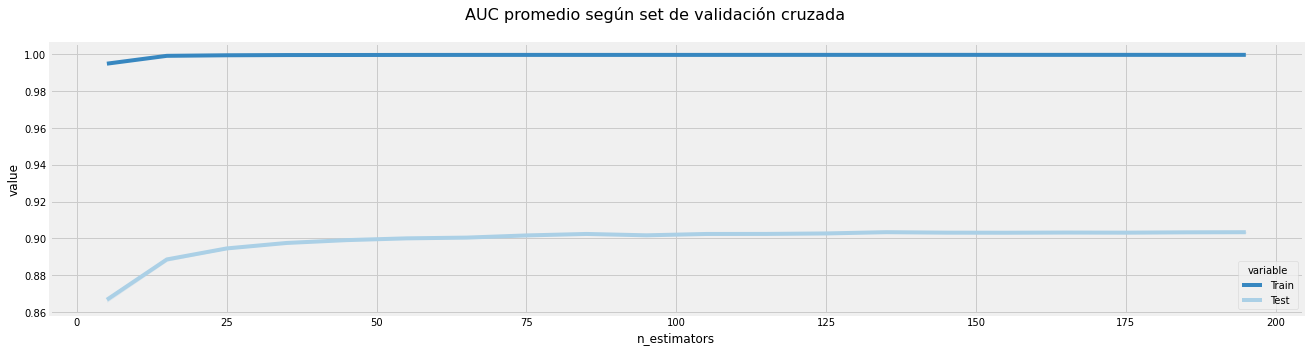

In [50]:
fig, axes = plt.subplots(ncols=1, figsize=(20, 5))
fig.suptitle("AUC promedio según set de validación cruzada", fontsize=16)

df_melt = rf_df.melt(id_vars=['n_estimators'],value_vars= ['mean_train_score','mean_test_score'])
df_melt.variable.replace({'mean_train_score':'Train',
                'mean_test_score':'Test'},inplace=True)

sns.lineplot(data=df_melt, x='n_estimators', y="value", hue="variable", palette ='Blues_r')

# Importancia de variables

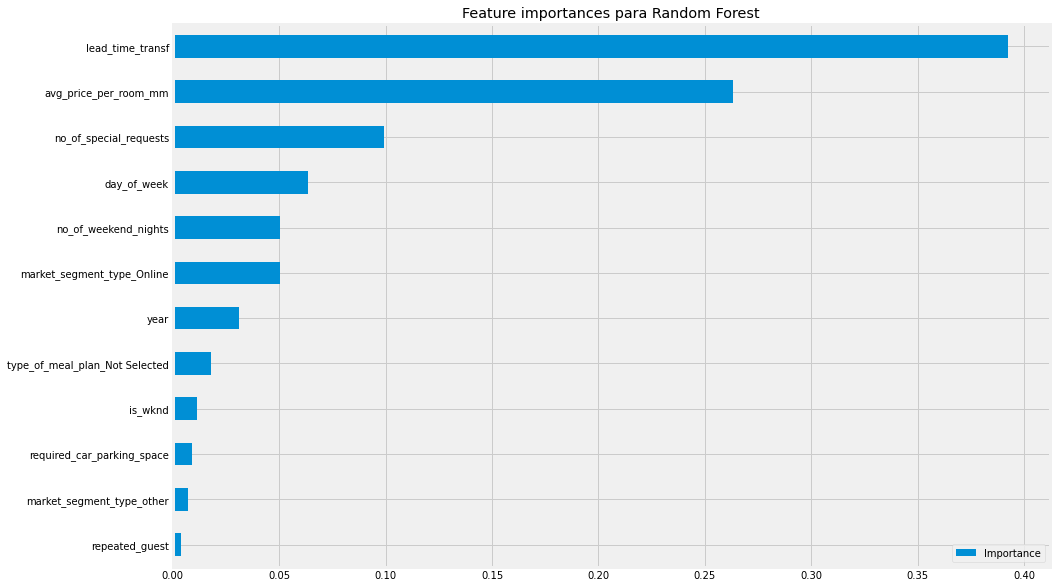

In [61]:
pd.DataFrame(grid_search_rf.best_estimator_.feature_importances_.tolist(), index=X_train.columns, columns=['Importance']).sort_values('Importance').plot.barh(figsize=(14,10))
plt.title('Feature importances para Random Forest')
plt.show()

# Resultados CV test

In [68]:
results = cross_validate(
    grid_search_rf.best_estimator_,
    X_train,
    y_train,
    cv=kfold,
    scoring=['accuracy', 'precision', 'recall', "f1", "roc_auc"],
    return_train_score=False,
    n_jobs=-1
)

results_rf = pd.DataFrame(results)

In [69]:
mean_results = pd.DataFrame(results_rf.mean(axis=0), columns=['test_cv'])
mean_results

,test_cv
fit_time,1.11
score_time,0.11
test_accuracy,0.84
test_precision,0.78
test_recall,0.71
test_f1,0.75
test_roc_auc,0.90


In [70]:
mean_results.to_csv('../data/cv_results/randomforest.csv', index=False)

# Resultados test

In [71]:
preds = grid_search_rf.predict(X_test)
print(classification_report(y_test,preds))
print(roc_auc_score(y_test,preds))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       603
           1       0.75      0.70      0.72       297

    accuracy                           0.82       900
   macro avg       0.80      0.79      0.80       900
weighted avg       0.82      0.82      0.82       900

0.7912960450273883


# Guardamos modelo y resultados

In [72]:
resultados_dict = {
    'AUC': roc_auc_score(y_test,preds),
    'Accuracy': accuracy_score(y_test,preds),
    'Recall': recall_score(y_test,preds),
    'Precision': precision_score(y_test,preds),
    'F1_score': f1_score(y_test,preds)
}

In [73]:
resultados = pd.DataFrame(resultados_dict,index=['Resultados en test']).T

In [74]:
resultados

,Resultados en test
AUC,0.79
Accuracy,0.82
Recall,0.70
Precision,0.75
F1_score,0.72


In [75]:
resultados.to_csv('../data/resultados/random_forest.csv',index=False)

In [76]:
import pickle
pickle.dump(grid_search_rf, open('../data/modelos/random_forest.pkl', 'wb'))